# Train classifier for detecting chirps of bat B


Import modules

In [3]:
from __future__ import print_function, division
import sys
import os
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import librosa as lb # signal processing
## machine learning tools
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, train_test_split #cross_val_score
#import sklearn.base as skb
import sklearn.metrics as mt
%matplotlib inline  

import pylotwhale.MLwhales.featureExtraction as fex
import pylotwhale.MLwhales.MLtools_beta as myML
import pylotwhale.utils.plotTools as pT
import pylotwhale.MLwhales.predictionTools as pdT

from pylotwhale.MLwhales.clf_pool import svc_l, svc_rbf, random_forest # as clf_settings

In [ ]:
sns.set_context('paper', font_scale=2) # plotting settings

## Set paths


In [4]:
flacDir = './data/bats/'  # directory of audio files
recl = 'recording'  # 
oFigDir = './data/bats/' # output path

clf_id_str = 'Bat_B' # bat we want to train a model on

## Load annotations

In [29]:
inF =  './data/bats/bat_annotations.csv'
df = pd.read_csv(inF)

print(len(df))
print("# Annotations {}\nby class {}\nby recording {}".format(len(df), 
                                                              Counter(df['type']),
                                                              Counter(df['recording'])))


df.head()

63
# Annotations 63
by class Counter({'Bat_B': 45, 'background': 12, 'Bat_A': 4, 'Bat_C': 2})
by recording Counter({'HFr2_US6_20170117_183200.flac': 46, 'HFr2_US6_20170117_182200.flac': 17})


,recording,tmin,tmax,type
0,HFr2_US6_20170117_182200.flac,123.2,125.5,Bat_A
1,HFr2_US6_20170117_182200.flac,56.0,58.0,background
2,HFr2_US6_20170117_182200.flac,10.0,11.0,background
3,HFr2_US6_20170117_182200.flac,374.0,376.0,background
4,HFr2_US6_20170117_182200.flac,6.0,7.0,Bat_A


### Visualise the spectrogram of one sample

load the i-th waveform

In [13]:
i = 14
thisRec = df.iloc[i].to_dict()
print(thisRec['type'])

w_buffer = 0.25 # load 0.25 s around the sound of interest for visualisation
## load
yi, sr = lb.core.load(os.path.join(flacDir, thisRec[recl]), offset=thisRec['tmin']-w_buffer,
                     sr=None, duration = thisRec['tmax'] - thisRec['tmin'] + 2*w_buffer)

print(thisRec['tmin'], thisRec['tmax'], thisRec[recl])

Bat_B
306.22 306.255 HFr2_US6_20170117_182200.flac


plot spectrogram

'./data/bats/14_Bat_B.png'

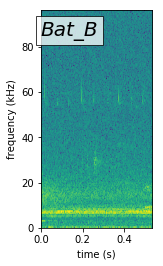

In [14]:
fig, ax = plt.subplots(figsize=(2,4))

fig, ax = pT.plspectro(yi, sr, spec_fac=1, ax=ax, xl='time (s)', yl='frequency (kHz)', cmN='viridis', fig=fig)

ax.text(0, 85, '{}'.format(thisRec['type']), style='italic', fontsize=20,
        bbox={'facecolor':'white', 'alpha':0.75, 'pad':5})

oFig = os.path.join(oFigDir, '{}_{}.png'.format(i, thisRec['type']))
#fig.savefig(oFig, bbox_inches='tight')
oFig

#### Choose size of the decision window

In [15]:
yi, sr = lb.core.load(os.path.join(flacDir, thisRec[recl]), offset=thisRec['tmin'],
                     sr=None, duration = thisRec['tmax'] - thisRec['tmin'])


fft_ws = 512
sum_ws = 5
print("One instance has ca. {} points => {:.2f} s".format(len(yi), len(yi)/sr))
      
print("FFT ws: {} {:.2} s\nsumm ws: {}\nDecision window: {:.2} s".format(fft_ws, fft_ws/sr,
                                                                           sum_ws, sum_ws*fft_ws/sr))

One instance has ca. 6720 points => 0.04 s
FFT ws: 512 0.0027 s
summ ws: 5
Decision window: 0.013 s


## Feature extraction settings

Create pipeline for the feature extraction settings

**y** settings

In [16]:
labels = list(set(df['type']))
print("All classes:", labels)

classes = ['background'] + clf_id_str.split('-')
lt = myML.labelTransformer(classes)
print("Classes we train on:", lt.classes_)

All classes: ['Bat_A', 'Bat_C', 'Bat_B', 'background']
Classes we train on: ['Bat_B' 'background']


**X** settings

In [17]:
#### initialise transformation settings
T_settings = []

#### preprocessing
## band pass filter
filt = 'band_pass_filter'
filtDi = {"fs": sr, "lowcut": 10000, "highcut": 50000, "order": 5}
T_settings.append(('bandFilter', (filt, filtDi)))
## normalisation
prepro = 'maxabs_scale'
preproDict = {}
T_settings.append(('normaliseWF', (prepro, preproDict)))

#### audio features
auD = {}
auD["fs"] = sr
auD["NFFT"] = fft_ws
auD["overlap"] = 0.5
auD["n_mels"] = 8
auD["fmin"] = 9000
audioF = 'melspectro' #'MFCC'
T_settings.append(('Audio_features', (audioF, auD)))

#### summarisation features
summDict = {'n_textWS': sum_ws, 'normalise': True}
summType = 'walking'
T_settings.append(('summ', (summType, summDict)))

Tpipe = fex.makeTransformationsPipeline(T_settings)
print(T_settings)
print(Tpipe.string)

feExFun = Tpipe.fun

[('bandFilter', ('band_pass_filter', {'lowcut': 10000, 'highcut': 50000, 'fs': 192000, 'order': 5})), ('normaliseWF', ('maxabs_scale', {})), ('Audio_features', ('melspectro', {'fmin': 9000, 'n_mels': 8, 'fs': 192000, 'overlap': 0.5, 'NFFT': 512})), ('summ', ('walking', {'normalise': True, 'n_textWS': 5}))]
-bandFilter-band_pass_filter-lowcut_10000-highcut_50000-order_5-fs_192000-normaliseWF-maxabs_scale-Audio_features-melspectro-NFFT_512-n_mels_8-fs_192000-overlap_0.5-fmin_9000-summ-walking-normalise_True-n_textWS_5


#### Extract features and create data object

In [18]:
datO = myML.dataXy_names()

for idx, s in df[:].iterrows():
    if s['type'] in classes: # check if the annotated section is one of the classes if interest

        t0 = s['tmin']
        tf = s['tmax']
        ## load waveform
        y, sr = lb.core.load(os.path.join(flacDir, s[recl]), offset=t0,
                              sr=None, duration=tf-t0)
        ## extract features
        try:
            M0 = feExFun(y)
        except AssertionError: # ignore if the sample is too short for the analysis window
            print(idx, s['type'], "skipping")
            continue
        labs = np.repeat(s['type'], len(M0)) # label instances
        datO.addInstances(M0, labs) # add features and instances to data object

Class counts

In [19]:
X0 = datO.X
y0_names = datO.y_names
y0 = lt.nom2num(y0_names)
print("Class counts", datO.targetFrequencies())

Class counts {'Bat_B': 192, 'background': 1838}


### Balance samples to the number of Bat_B samples

by randomly drawing 'background' samples

In [20]:
X, y_names = myML.balanceToClass(X0, y0_names, class_label='Bat_B')
y = lt.nom2num(y_names)
print(Counter(y_names), lt.targetNumNomDict())

Counter({'Bat_B': 192, 'background': 192}) {0: 'Bat_B', 1: 'background'}


Visualise features

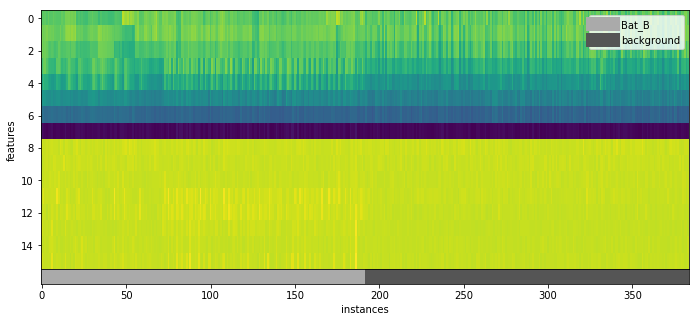

In [21]:
myML.plXy(X.T, y_names, figsize=(10,4), cmapName_Fig='viridis')

oFig = os.path.join(oFigDir, Tpipe.string + '.png')

oFig = os.path.join(oFigDir, 'feature_matrix-{}.png'.format('_'.join(classes)))
#plt.savefig(oFig, bbox_inches='tight')

## Train model

### Split data into train and test sets and shuffle samples

Counter({0: 155, 1: 152}) Counter({1: 40, 0: 37})


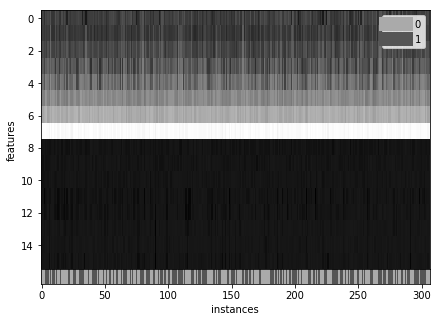

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    random_state=0)

myML.plXy(X_train.T, y_train) # visualise train set
print(Counter(y_train), Counter(y_test))

### Carry out a grid search to tune classifier hyperparameters


Classifier settings

In [23]:
clf_settings = random_forest #svc_rbf# # svc_l #
cv = 10  # cross validation folds for hyperparameter tuning via grid search
scoring = mt.make_scorer(mt.f1_score, labels=lt.nom2num('Bat_B'))#, average='macro') #'accuracy'

## define clf pipeline
clf_pipe = []
clf_pipe.append((clf_settings.pipeStep_name,  clf_settings.fun))
pipe = Pipeline(clf_pipe)
print("Clf pipeline:", clf_pipe)

## grid search parameters
paramsDi = {}
paramsDi.update(clf_settings.grid_params_di)
gs_grid = [paramsDi]
print("\nGrid search parameters:", paramsDi)
gs = GridSearchCV(estimator=pipe,
                  param_grid=gs_grid,
                  scoring=scoring,
                  cv=cv,
                  n_jobs=-1)

Clf pipeline: [('clf', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))]

Grid search parameters: {'clf__bootstrap': [True, False], 'clf__max_depth': [3, None], 'clf__n_estimators': [50, 100]}


Fit model

In [ ]:
gs = gs.fit(X_train, y_train)

# print scores
clf_svc_best = gs.best_estimator_
print(scoring, clf_svc_best )
print(gs.best_score_)

print score

## Evaluate model on test set

### Print P, R and f1 scores for test collection

Scores by class and scoring summary

In [ ]:
y_true, y_pred = y_test, clf_svc_best.predict(X_test)
print(mt.classification_report(y_true, y_pred, target_names=lt.num2nom(list(set(y)))))

## confusion matrix
cm = mt.confusion_matrix(y_true, y_pred)  # counts
cm_n = myML.scale(cm, normfun=myML.colCounts2colFreqs) # normalised for each class

fig, ax = myML.plConfusionMatrix(cm_n, labels=lt.num2nom([0,1]), figsize=(2.3, 2.3), 
                                 alpha=0.53, display_nums=False)

pT.display_numbers(fig, ax, cm_n, 18, 
                   fmt = lambda x: np.round(x, decimals=2), # display numbers with a 2 digit precision
                   condition=lambda x: x>0) # omit zeros

#ofig = os.path.join(oDir, 'CM-normalised.png')
#fig.savefig(ofig,  bbox_inches='tight')

## Train model over all data and save for later use

In [ ]:
clf = gs.best_estimator_.fit(X,y)

In [ ]:
### ------------ UNCOMMENT TO SAVE MODEL FOR LATER USE -----------------
outModelName = os.path.join('../', 'models',  Tpipe.string + '-' + clf_id_str)
#myML.saveModel(clf, outModelName )
#print(outModelNam, clf.classes_)

## Predict annotations

Settings: paths and sections we want to annotate

In [ ]:
audioF = '../data/bats/HFr2_US6_20170117_182200.flac' # path to wav file we want to annotate

outDir = '../data/bats/' # path to output file (annotations)
bN = os.path.splitext(os.path.basename(audioF))[0]
outTxt = os.path.join(outDir, bN + '-{}-{}.txt'.format(clf_id_str, clf_settings.clf_name))
keepClasses = clf_id_str.split('-')
print(outTxt)

Generate annotations

In [ ]:
pdT.predictSoundSections(audioF, clf,  lt, feExFun, outF=outTxt, annSections=keepClasses)#clf_id_str.split('-')] )